In [46]:
!pip install evaluate rouge_score

  Preparing metadata (setup.py) ... done
  Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
  DEPRECATION: rouge_score is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  Running setup.py install for rouge_score ... done

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [62]:
import torch
import torchvision.transforms as transforms
from dataset import TestDataset
from model import CNNtoRNN
import matplotlib.pyplot as plt  
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.gleu_score import sentence_gleu
from nltk.translate.meteor_score import single_meteor_score
import evaluate
import nltk
nltk.download('wordnet')

IMAGES_PATH = './data/Images'
CAPTIONS_PATH = './data/captions.txt'

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ArsalanAnwar/nltk_data...


In [21]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [22]:
test_dataset = TestDataset(CAPTIONS_PATH, IMAGES_PATH, transform=transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ]
    ))

In [23]:
model = CNNtoRNN(embed_size=256, hidden_size=256, vocab_size=len(test_dataset.caption_vocab), num_layers=3).to(device)


In [25]:
checkpoint = torch.load('./epoch=10_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

CNNtoRNN(
  (encoder): EncoderCNN(
    (cnn): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (rel

In [56]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"TOTAL PARAMS: {pytorch_total_params}")
print(f"TOTAL TRAINABLE PARAMS {pytorch_total_trainable_params}")

TOTAL PARAMS: 93475200
TOTAL TRAINABLE PARAMS 6732864


In [35]:
vocab = test_dataset.caption_vocab.to(device)
results = []
predictions = []
references = []

for idx, (img_label, img, caption) in enumerate(test_dataset):
    sample_img = img.to(device)
    sample_img_label = img_label
    sample_img_caption = caption
    generated_caption = model.caption_image(sample_img, vocab)
    target_caption = [vocab.lookup_token(token) for token in caption]
    reference = ' '.join(target_caption[1:-2])
    prediction = ' '.join(generated_caption[1:-2])
    result = {
        'img_label': img_label,
        'img': img.T,
        'target_caption': [vocab.lookup_token(token) for token in caption],
        'generated_caption': generated_caption
    }
    results.append(result)
    references.append([reference])
    predictions.append(prediction)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./data/Images/1000268201_693b08cb0e.jpg
['<bos>', 'A', 'little', 'girl', 'in', 'a', 'pink', 'dress', 'going', 'into', 'a', 'wooden', 'cabin', '.', '\n', '<eos>']
['<bos>', 'A', 'young', 'boy', 'is', 'sitting', 'on', 'a', 'swing', '.', '\n', '<eos>']


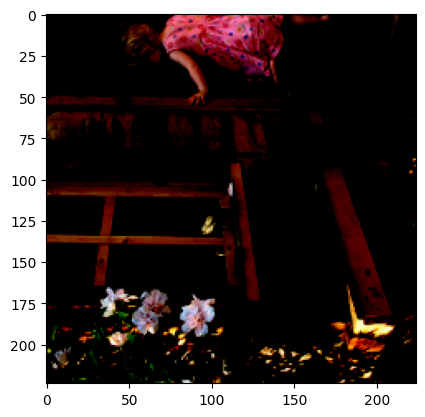

In [37]:
plt.imshow(results[0]['img'])
print(results[0]['img_label'])
print(results[0]['target_caption'])
print(results[0]['generated_caption'])


In [63]:
number_samples = 0
sum_bleu_scores = 0
sum_gleu_scores = 0
sum_meteor_scores = 0
for result in results:
    number_samples += 1
    
    sample_references = [result['target_caption']]
    candidates = result['generated_caption']
    sum_bleu_scores += sentence_bleu(sample_references, candidates)
    sum_gleu_scores = sentence_gleu(sample_references, candidates)
    sum_meteor_scores += single_meteor_score(result['target_caption'], result['generated_caption'])

/Users/ArsalanAnwar/Desktop/Arsalan Anwar/repos/DL-final/img_cap_env/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/ArsalanAnwar/Desktop/Arsalan Anwar/repos/DL-final/img_cap_env/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [64]:
avg_bleu_score = sum_bleu_scores / number_samples
print(f"BLEU SCORE: {avg_bleu_score}")

avg_gleu_score = sum_gleu_scores / number_samples
print(f"GLEU SCORE: {avg_gleu_score}")

avg_meteor_score = sum_meteor_scores / number_samples
print(f"METEOR SCORE: {avg_meteor_score}")

BLEU SCORE: 0.019385164749741102
GLEU SCORE: 2.3921441984522827e-05
METEOR SCORE: 0.39949680522566106


In [65]:
' '.join(results[4]['target_caption'][1:-2])

'The man with pierced ears is wearing glasses and an orange hat .'

In [48]:
def print_evaluation_results(results_dict):
    for key in results_dict.keys():
        print(f"{key} : {results_dict[key]}")

In [66]:
bleu = evaluate.load("bleu")

bleu_results = bleu.compute(predictions=predictions, references=references)

print_evaluation_results(bleu_results)

bleu : 0.02933810636841104
precisions : [0.26354865645214837, 0.04797941079837915, 0.013338300147802785, 0.004392503460760302]
brevity_penalty : 1.0
length_ratio : 1.1258466417487825
translation_length : 99401
reference_length : 88290


In [67]:
rouge = evaluate.load("rouge")

rouge_results = rouge.compute(predictions=predictions, references=references)

print_evaluation_results(rouge_results)

rouge1 : 0.23523958468706824
rouge2 : 0.053560287200093794
rougeL : 0.21420045282752215
rougeLsum : 0.2140237842654455
